# Forschungspraktikum SS20 
# Semantic Differentials for Wikipedia using the POLAR Framework


The POLAR Framework is a method that enables Interpretability for pre-trained word embeddings. The goal of this project is to produce word embeddings from a Wikipedia dataset, and deploy the POLAR framework to different categories of words (e.g. Countries, Politicians, Music, etc) in order to explain the semantic associations behind concepts on Wikipedia. An evaluation setup should assess the quality of the semantic differentials produced.

In [1]:

import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import multiprocessing
from gensim.corpora.wikicorpus import WikiCorpus #https://radimrehurek.com/gensim/corpora/wikicorpus.html
from gensim.models.word2vec import Word2Vec

# Only run next cell if a new Wikipedia dataset is loaded

In [2]:
trainNewModel=False
loadNewDataset= False

In [3]:
if trainNewModel==True:
    wiki = WikiCorpus(r"C:\Users\Jan\Desktop\PraktikumSS20\Semantic-Differentials-for-Wikipedia-using-the-POLAR-Framework\JanEngler\Praktikum\enwiki-20200401-pages-articles-multistream1.xml-p1p30303.bz2", 
                  lemmatize=False, dictionary={})
    #stores the preprocessed dataset, which reduces runtime for the future
    wiki.save('SavedWord2Vec/wiki.corpus')
    
    sentences = list(wiki.get_texts()) #Iterate over the dump, yielding a list of tokens for each article that passed the length and namespace filtering.



size: The number of dimensions of the embeddings and the default is 100.

window: The maximum distance between a target word and words around the target word. The default window is 5.

min_count: The minimum count of words to consider when training the model; words with occurrence less than this 
count will be ignored. The default for min_count is 5.

workers: The number of partitions during training and the default workers is 3.

sg: The training algorithm, either CBOW(0) or skip gram(1). The default training algorithm is CBOW.

In [7]:
### Compute the Word2Vec model usint following parameters#
# Currently using CBOW for testing because of performance issues of skip gram on my laptop #
if trainNewModel==True:
    print("Training Word2Vec model ...")
    params = {'size': 300, 'window': 5, 'min_count': 5, 
          'workers': max(1, multiprocessing.cpu_count() - 1), 'sample': 1E-3,'sg' : 1}
    word2vec = Word2Vec(sentences, **params)
    ### Save Word2Vec model to file ###
    word2vec.save('SavedWord2Vec/wiki.word2vec.model')
    print("Finished Training")
else:
    ### Loading finished Word2Vec model to memory from file ###
    print("Loading Word2Vec model from file...")
    word2vec = Word2Vec.load('SavedWord2Vec/wiki.word2vec.model')
    print("Finished Loading")


Loading Word2Vec model from file...
Finished Loading


In [9]:
print("Smiliarity of king and queen:", word2vec.wv.similarity('king', 'queen'))
ourQueen= word2vec.wv['king'] - word2vec.wv['man'] + word2vec.wv['woman']
print("Smiliarity of transformed king and queen:", similarityNameVector(ourQueen,'queen'))

word2vec.wv.most_similar(positive=[ourQueen], topn=10)




Smiliarity of king and queen: 0.61206675
Smiliarity of transformed king and queen: 0.58086324


[('king', 0.7404661178588867),
 ('queen', 0.5808632373809814),
 ('regnant', 0.5323577523231506),
 ('woman', 0.5306766629219055),
 ('consort', 0.4988700747489929),
 ('sibylla', 0.4976164400577545),
 ('monarch', 0.49684637784957886),
 ('berengaria', 0.4891374111175537),
 ('husband', 0.48792698979377747),
 ('isabeau', 0.4850718677043915)]

In [10]:
def similarityNameVector(vec, name):
    
    cosineSimilarity = np.dot(vec, word2vec.wv[name])/(np.linalg.norm(vec)* np.linalg.norm(word2vec.wv[name]))
    return cosineSimilarity

print(similarityNameVector(ourQueen,'queen'))



0.58086324


In [11]:
female_king = word2vec.most_similar_cosmul(positive='donald'.split(), 
                                           negative='mtu'.split(), topn=5,)
for ii, (word, score) in enumerate(female_king):
    print("{}. {} ({:1.2f})".format(ii+1, word, score))


1. griffiths (1.49)
2. earle (1.49)
3. lindsay (1.49)
4. lester (1.48)
5. melania (1.47)


C:\Users\Jan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  


In [12]:
print(word2vec.wv.similarity('germany', 'europe')) 
print(word2vec.wv.similarity('leyen', 'europe'))

0.52884626
0.23710738


However, Euclidian similarity cannot work well for the high-dimensional word vectors.
This is because Euclidian similarity will increase as the number of dimensions increases, even if the word embedding stands for different meanings.
Alternatively, we can use cosine similarity to measure the similarity between two vectors.
Mathematically, it measures the cosine of the angle between two vectors projected in a multi-dimensional space. The cosine similarity captures the angle of the word vectors and not the magnitude. Under cosine similarity, no similarity is expressed as a 90-degree angle while the total similarity of 1 is at a 0-degree angle.

In [13]:
word2vec.wv.similarity('star', 'hollywood')  
#'köln', 'akademie'

0.41214263

In [14]:
word2vec.wv.most_similar('afghanistan')[:20]

[('afghan', 0.7354598641395569),
 ('iran', 0.7224469184875488),
 ('kabul', 0.714802086353302),
 ('iraq', 0.7087748050689697),
 ('pakistan', 0.6993895769119263),
 ('taliban', 0.6594675779342651),
 ('tajikistan', 0.6579927206039429),
 ('herat', 0.6495062708854675),
 ('kargil', 0.6288100481033325),
 ('kandahar', 0.6270360946655273)]

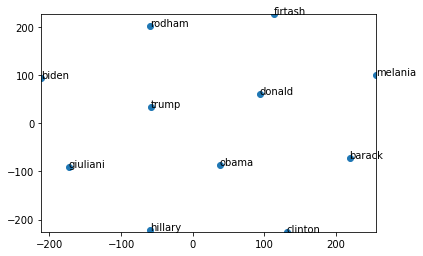

In [15]:
from sklearn.manifold import TSNE
def display_closestwords_tsnescatterplot(model, word, size):
    
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]
    close_words = model.wv.similar_by_word(word)
    #print(arr)
    #print(np.array([model[word]]))
    arr = np.append(arr, np.array([model.wv[word]]), axis=0)
    
    for wrd_score in close_words:
        wrd_vector = model.wv[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
        plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
        plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

    
display_closestwords_tsnescatterplot(word2vec, 'trump', 300) 

# Online training / Resuming training

Advanced users can load a model and continue training it with more sentences and new vocabulary words:

model = gensim.models.Word2Vec.load(temporary_filepath)
more_sentences = [
    ['Advanced', 'users', 'can', 'load', 'a', 'model',
     'and', 'continue', 'training', 'it', 'with', 'more', 'sentences']
]
model.build_vocab(more_sentences, update=True)
model.train(more_sentences, total_examples=model.corpus_count, epochs=model.iter)

cleaning up temporary file
import os
os.remove(temporary_filepath)

In [16]:
import numpy as np
import gensim
from numpy import linalg

from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm_notebook as tqdm
import time
from random import shuffle
import sys
import nltk 
from nltk.corpus import wordnet 
import gc
from collections import defaultdict
import random
import json
import os

from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.test.utils import datapath, get_tmpfile

from gensim.test.utils import datapath
#%load_ext autotime

In [17]:
current_model=model = word2vec

In [18]:
list_antonym = []

with open(r'C:\Users\Jan\Desktop\PraktikumSS20\POLAR-master\Antonym_sets\LenciBenotto.val') as fp:
    for line in fp:
        parts = line.split()
        if parts[3]=='antonym':
            word1 = parts[0].split('-')[0]
            word2 = parts[1].split('-')[0]
            if word1 in current_model and word2 in current_model:
                list_antonym.append((word1.strip().lower(), word2.strip().lower()))


with open(r'C:\Users\Jan\Desktop\PraktikumSS20\POLAR-master\Antonym_sets\LenciBenotto.test') as fp:
    for line in fp:
        parts = line.split()
        if parts[3]=='antonym':
            word1 = parts[0].split('-')[0]
            word2 = parts[1].split('-')[0]
            if word1 in current_model and word2 in current_model:
                list_antonym.append((word1.strip().lower(), word2.strip().lower()))
                
with open(r'C:\Users\Jan\Desktop\PraktikumSS20\POLAR-master\Antonym_sets\EVALution.val') as fp:
    for line in fp:
        parts = line.split()
        if parts[3]=='antonym':
            word1 = parts[0].split('-')[0]
            word2 = parts[1].split('-')[0]
            if word1 in current_model and word2 in current_model:
                list_antonym.append((word1.strip().lower(), word2.strip().lower()))
                
with open(r'C:\Users\Jan\Desktop\PraktikumSS20\POLAR-master\Antonym_sets\EVALution.test') as fp:
    for line in fp:
        parts = line.split()
        if parts[3]=='antonym':
            word1 = parts[0].split('-')[0]
            word2 = parts[1].split('-')[0]
            if word1 in current_model and word2 in current_model:
                list_antonym.append((word1.strip().lower(), word2.strip().lower()))
                
                
list_antonym = list(dict.fromkeys(list_antonym).keys())

C:\Users\Jan\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if __name__ == '__main__':
C:\Users\Jan\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Users\Jan\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Users\Jan\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).


In [19]:
print(list_antonym[0:50])
print(len(list_antonym))

[('implicate', 'exclude'), ('assertion', 'rejection'), ('terminal', 'beginning'), ('lop', 'secure'), ('pastor', 'libertine'), ('pocket', 'hook'), ('orbital', 'stationary'), ('evidence', 'disprove'), ('psychological', 'biological'), ('preparedness', 'unprepared'), ('saturation', 'dehydration'), ('geologic', 'biologic'), ('accessibility', 'secured'), ('fight', 'agree'), ('lump', 'smooth'), ('double', 'half'), ('training', 'forgetting'), ('determined', 'negligent'), ('velocity', 'still'), ('shield', 'vulnerable'), ('measurement', 'guess'), ('iconic', 'ordinary'), ('thump', 'caress'), ('stretcher', 'compressor'), ('allude', 'distract'), ('cemetery', 'birthplace'), ('corrupt', 'sanctify'), ('cameraman', 'actor'), ('knowledgeable', 'uninformed'), ('screech', 'talk'), ('hedge', 'squander'), ('aggregate', 'please'), ('constrict', 'open'), ('make', 'break'), ('normative', 'descriptive'), ('inscribe', 'polish'), ('bulge', 'hollow'), ('edit', 'expand'), ('sensory', 'numb'), ('immobilize', 'move')

In [20]:
similarity_matrix = defaultdict(list)
print(similarity_matrix)
for each_pair in tqdm(list_antonym):
    word1 = each_pair[0]
    word2 = each_pair[1]
    #print(each_pair)
    #print(word1 < word2)
    
    if word1 < word2: ## welches wort länger ist
        similarity_matrix[word1].append(word2)                  #defaultdict(<class 'list'>, {'exclude': ['inscribe']})
        #print(similarity_matrix)
    else:
        similarity_matrix[word2].append(word1)
    
all_similarity = defaultdict(dict)
for each_key in tqdm(similarity_matrix):
    for each_value in similarity_matrix[each_key]:
#         cosine_similarity([current_model[each_key]]
        all_similarity[each_key][each_value] = abs(cosine_similarity([current_model.wv[each_key]],[current_model.wv[each_value]])[0][0])
        #print(current_model[each_key])
        #print(current_model[each_value])
        #print(all_similarity[each_key][each_value])
       
final_antonym_list = []
for index_counter, each_key in enumerate(tqdm(all_similarity)):
#     print(each_key,all_similarity[each_key])
    listofTuples = sorted(all_similarity[each_key].items() ,  key=lambda x: x[1])
    #print(listofTuples)
    final_antonym_list.append((each_key, listofTuples[0][0]))
 
print(final_antonym_list)

list_antonym = final_antonym_list

defaultdict(<class 'list'>, {})


[('exclude', 'inscribe'), ('assertion', 'lazy'), ('beginning', 'terminal'), ('lop', 'secure'), ('libertine', 'pastor'), ('hook', 'pocket'), ('orbital', 'stable'), ('disprove', 'document'), ('biological', 'psychological'), ('preparedness', 'unplanned'), ('dehydration', 'saturation'), ('biologic', 'geologic'), ('accessibility', 'secured'), ('agree', 'crab'), ('lump', 'spread'), ('double', 'indivisible'), ('forgetting', 'training'), ('determined', 'lazy'), ('still', 'velocity'), ('shield', 'vulnerable'), ('guess', 'measurement'), ('iconic', 'ordinary'), ('caress', 'punch'), ('compressor', 'stretcher'), ('allude', 'declare'), ('birthplace', 'cemetery'), ('corrupt', 'honor'), ('actor', 'cameraman'), ('knowledgeable', 'naive'), ('screech', 'talk'), ('hedge', 'plain'), ('aggregate', 'please'), ('constrict', 'release'), ('break', 'connect'), ('descriptive', 'normative'), ('inscribe', 'polish'), ('bulge', 'compress'), ('edit', 'include'), ('numb', 'sensory'), ('immobilize', 'tour'), ('iodine', 

In [21]:
print(len(list_antonym))

1409


In [22]:
num_antonym = 50#1468

In [23]:
## Find the antonym difference vectors
antonymy_vector = []
for each_word_pair in list_antonym:
    antonymy_vector.append(current_model.wv[each_word_pair[0]]- current_model.wv[each_word_pair[1]])
antonymy_vector = np.array(antonymy_vector)
print(antonymy_vector.shape)

(1409, 300)


In [24]:
print(list_antonym[2])

('beginning', 'terminal')


## Subset Dimension Selection Method

In [25]:
import random

from scipy.spatial.distance import cosine as scipy_cosine
random.seed(42)

t1 = np.array(antonymy_vector)
dimension_similarity_matrix = defaultdict(dict)
for index_1, each_dim1 in enumerate(tqdm(t1)):
    for index_2, each_dim2 in enumerate(t1):
        dimension_similarity_matrix[index_1][index_2] = abs(1-scipy_cosine(each_dim1, each_dim2))
        
        
def get_set_score(final_list, each_dim):
    final_output = 0.0
    for each_vec in final_list:
        final_output += dimension_similarity_matrix[each_vec][each_dim]
    return final_output/(len(final_list))
        
def select_subset_dimension(dim_vector, num_dim):
    working_list = np.array(dim_vector)
    
    working_position_index = [i for i in range(working_list.shape[0])]
    final_position_index = []
    

    print('working list is ready, shape', working_list.shape)
    sel_dim = random.randrange(0, working_list.shape[0])

    final_position_index.append(sel_dim)
    
    working_position_index.remove(sel_dim)

    
    for test_count in tqdm(range(num_dim-1)):
        min_dim = None
        min_score = 1000
        for temp_index, each_dim in enumerate(working_position_index):
#             print(each_dim)
            temp_score = get_set_score(final_position_index, each_dim)
            if temp_score< min_score:
                min_score= temp_score
                min_dim = each_dim
        print(test_count,min_dim)
        final_position_index.append(min_dim)
        working_position_index.remove(min_dim)
#         print(working_list.shape, len(final_list))
    return final_position_index

## Generate the ORTHOGONAL DIMENSION Order

## Generate the ORTHOGONAL DIMENSION Order

In [194]:
num_antonym = 1400
orthogonal_antonymy_vector =np.array(select_subset_dimension(antonymy_vector, num_antonym))  
print(orthogonal_antonymy_vector.shape)
print(orthogonal_antonymy_vector)

working list is ready, shape (1409, 300)


0 182
1 940
2 1308
3 1323
4 399
5 1407
6 321
7 1363
8 1382
9 870
10 875
11 148
12 1202
13 522
14 1400
15 1205
16 723
17 848
18 1076
19 293
20 1374
21 1332
22 782
23 316
24 1078
25 1074
26 429
27 981
28 653
29 397
30 1285
31 1339
32 1236
33 1260
34 1321
35 1275
36 975
37 995
38 862
39 411
40 612
41 442
42 1247
43 1248
44 683
45 668
46 87
47 475
48 784
49 474
50 233
51 1132
52 982
53 734
54 1290
55 150
56 483
57 1406
58 1034
59 988
60 1159
61 1162
62 497
63 854
64 1295
65 620
66 669
67 1354
68 567
69 404
70 367
71 718
72 665
73 1223
74 123
75 985
76 1330
77 1394
78 1152
79 1318
80 1010
81 552
82 1369
83 1252
84 1362
85 1270
86 874
87 760
88 1312
89 1117
90 1102
91 709
92 924
93 1002
94 828
95 25
96 936
97 1399
98 1104
99 344
100 861
101 845
102 1014
103 1226
104 842
105 329
106 595
107 93
108 671
109 214
110 1264
111 1359
112 1031
113 1307
114 571
115 1153
116 125
117 750
118 5
119 492
120 484
121 121
122 906
123 1287
124 946
125 885
126 1179
127 1344
128 1033
129 616
130 1351
131 868
13

1001 361
1002 727
1003 47
1004 363
1005 1142
1006 431
1007 715
1008 542
1009 381
1010 779
1011 1221
1012 999
1013 88
1014 721
1015 761
1016 966
1017 485
1018 929
1019 968
1020 39
1021 606
1022 96
1023 197
1024 191
1025 368
1026 855
1027 1185
1028 1392
1029 198
1030 1335
1031 941
1032 763
1033 640
1034 1300
1035 770
1036 30
1037 134
1038 536
1039 201
1040 193
1041 1396
1042 349
1043 15
1044 865
1045 1073
1046 116
1047 987
1048 61
1049 436
1050 2
1051 631
1052 1235
1053 597
1054 109
1055 250
1056 378
1057 991
1058 115
1059 642
1060 17
1061 69
1062 1294
1063 594
1064 1224
1065 1378
1066 655
1067 105
1068 869
1069 543
1070 86
1071 1278
1072 568
1073 667
1074 883
1075 469
1076 783
1077 451
1078 427
1079 692
1080 901
1081 41
1082 1122
1083 938
1084 274
1085 340
1086 390
1087 762
1088 336
1089 393
1090 183
1091 54
1092 229
1093 1172
1094 1184
1095 242
1096 944
1097 309
1098 369
1099 816
1100 553
1101 49
1102 695
1103 415
1104 1302
1105 1345
1106 895
1107 186
1108 505
1109 607
1110 325
1111 73

## Generate the RANDOM DIMENSION Order

## Generate the RANDOM DIMENSION Order

In [27]:
random_antonym_vector = [i for i in range(len(antonymy_vector))]
random.shuffle(random_antonym_vector)
print(len(random_antonym_vector))

1409


## Generate the MAXIMUM VARIANCE DIMENSION Order

## Generate the MAXIMUM VARIANCE DIMENSION Order

In [195]:
embedding_size = antonymy_vector.shape[0]   
print('The embedding size is', embedding_size)


variance_antonymy_vector_inverse = np.linalg.pinv(np.transpose(antonymy_vector))

embedding_matrix = []


total_words = 0
for each_word in tqdm(current_model.wv.vocab):
    total_words += 1

    new_vector = np.matmul(variance_antonymy_vector_inverse,current_model[each_word])
    
    embedding_matrix.append(new_vector)


The embedding size is 1409


C:\Users\Jan\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [196]:
del new_vector

In [197]:
variance_list = []

embedding_matrix = np.array(embedding_matrix)

for each_dimension in tqdm(range(embedding_matrix.shape[1])):
    variance_list.append(np.var(embedding_matrix[:,each_dimension]))

In [198]:
variance_antonymy_vector = [each for each in sorted(range(len(variance_list)), key=lambda i: variance_list[i], reverse=True)]

In [199]:
del embedding_matrix

In [200]:
del variance_list

# Transformation to polar space

# Transformation to polar space

In [201]:
def transform_to_antonym_space(current_model, output_file_path, binary, current_antonymy_vector_inverse):
    embedding_size = orthogonal_antonymy_vector.shape[0] #current_antonymy_vector_inverse.shape[0]   ##CHANGE THIS ACCORDINGLY!!!
    print('New model size is',len(current_model.wv.vocab), embedding_size)

    temp_file = None
    
    if binary:
        temp_file = open(output_file_path,'wb')
        temp_file.write(str.encode(str(len(current_model.wv.vocab))+' '+str(embedding_size)+'\n'))
    else:
        temp_file = open(output_file_path,'w')
        temp_file.write(str(len(current_model.wv.vocab))+' '+str(embedding_size)+'\n')

    total_words = 0
    for each_word in tqdm(current_model.wv.vocab):
        total_words += 1
        if binary:
            temp_file.write(str.encode(each_word+' '))
        else:
            temp_file.write(each_word+' ')

        new_vector = np.matmul(current_antonymy_vector_inverse,current_model[each_word])

        new_vector = new_vector/linalg.norm(new_vector)

        
        
        if binary:
            temp_file.write(new_vector)
            temp_file.write(str.encode('\n'))
        else:
            temp_file.write(str(new_vector))
            temp_file.write('\n')


    temp_file.close()



# Standard normal transform 

In [202]:
def standard_normal_dist_model(model, new_filename):
    embedding_matrix = []
    embedding_vocab = []

    temp_file = open(new_filename,'wb')
    temp_file.write(str.encode(str(model.vectors.shape[0])+' '+str(model.vectors.shape[1])+'\n'))
    
    for each_word in tqdm(model.wv.vocab):
        embedding_matrix.append(model[each_word])
        embedding_vocab.append(each_word)
    
    embedding_matrix = np.array(embedding_matrix)
    
    print('The shape of embedding matrix is {}'.format(embedding_matrix.shape))
    
    norm_embedding_matrix = (embedding_matrix - embedding_matrix.mean(0))/ embedding_matrix.std(0)
    
    for word_counter, each_word in enumerate(tqdm(embedding_vocab)):
#         assert each_word==embedding_vocab[word_counter],'Not matching!!!'
        
        temp_file.write(str.encode(each_word+' '))
        new_vector = norm_embedding_matrix[word_counter]
        temp_file.write(new_vector)
        temp_file.write(str.encode('\n'))
        
    del embedding_matrix
    del embedding_vocab
    temp_file.close()

## Compute the task score for different dimension size

In [203]:
def generate_embedding_path(current_model, embedding_path, binary, antonym_vector, curr_dim):
    curr_antonym_vector = antonymy_vector[antonym_vector[:curr_dim]]
    curr_antonymy_vector_inverse = np.linalg.pinv(np.transpose(curr_antonym_vector))
    transform_to_antonym_space(current_model, embedding_path, binary,curr_antonymy_vector_inverse)

In [204]:
import subprocess
#dim_size = 500 # Number of POLAR dimenions
antonym_vector_method = orthogonal_antonymy_vector#random_antonym_vector # orthogonal_antonymy_vector, variance_antonymy_vector

In [205]:
curr_dim = len(antonym_vector_method)#dim_size

embedding_path = r'C:\Users\Jan\Desktop\PraktikumSS20\Semantic-Differentials-for-Wikipedia-using-the-POLAR-Framework\JanEngler\Praktikum\polarEmbedding'+str(curr_dim)+'.bin'
generate_embedding_path(current_model, embedding_path,True,antonym_vector_method, curr_dim)

print('loading the model')
temp_model = gensim.models.KeyedVectors.load_word2vec_format(embedding_path, binary=True)
print('loading done..')

std_nrml_embedding_path = r'C:\Users\Jan\Desktop\PraktikumSS20\Semantic-Differentials-for-Wikipedia-using-the-POLAR-Framework\JanEngler\Praktikum\polarEmbedding'+str(curr_dim)+'_StdNrml.bin'
standard_normal_dist_model(temp_model, std_nrml_embedding_path)



New model size is 147612 1400


C:\Users\Jan\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



loading the model
loading done..


C:\Users\Jan\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  



The shape of embedding matrix is (147612, 1400)


In [206]:
#curr_dim=500
path=r'C:\Users\Jan\Desktop\PraktikumSS20\Semantic-Differentials-for-Wikipedia-using-the-POLAR-Framework\JanEngler\Praktikum\polarEmbedding'+str(curr_dim)+'_StdNrml.bin'
#f = open(path, "r+b")
#f.seek(0)
#print(f)
word2vecPolar = gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)
print("Finished Loading")

Finished Loading


In [207]:
word2vecPolar["test"].shape

(1400,)

In [41]:
word2vec.wv.most_similar(positive=["queen"], topn=10)

[('elizabeth', 0.6454077959060669),
 ('isabeau', 0.6140128374099731),
 ('margrethe', 0.6124271154403687),
 ('king', 0.6120667457580566),
 ('regnant', 0.6019624471664429),
 ('ranavalona', 0.5951443910598755),
 ('princess', 0.5911498069763184),
 ('salote', 0.5861144065856934),
 ('boleyn', 0.5729297399520874),
 ('consort', 0.5716495513916016)]

In [231]:
word2vecPolar.wv.most_similar(positive=["angela"], topn=10)

C:\Users\Jan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


[('merkel', 0.4618642330169678),
 ('caroline', 0.41549941897392273),
 ('michelle', 0.38424885272979736),
 ('alison', 0.37610459327697754),
 ('nina', 0.3760700225830078),
 ('linda', 0.3720398545265198),
 ('laura', 0.3708687424659729),
 ('marianne', 0.363736629486084),
 ('rudolf', 0.35618212819099426),
 ('dieter', 0.3521803617477417)]

In [43]:
#print(list_antonym)
count=0
for i in list_antonym:
    #print(type(i))
    if i == ('common', 'royal'):
        print(count)
    count+=1
print(list_antonym[1166])

1166
('common', 'royal')


In [44]:
orthogonal_antonymy_vector

array([1309,  513,  852,  729,  994,  292, 1153, 1323, 1217, 1147,  218,
       1129, 1289,  484, 1347, 1150, 1231, 1161, 1293,  975,  592, 1252,
       1037,  228,  932, 1168,  615,  734, 1028,  946, 1406, 1166,  786,
        571, 1209, 1256, 1393,  492,  397, 1226,  171,  150, 1342,  731,
       1269,  874,  291,  595,  403, 1040,  577,  850, 1223,  321, 1247,
       1205, 1270, 1332,   35, 1354,  913,  554, 1262,  921,  522, 1330,
        909, 1132,  908, 1106,  317,  766,  885,  891,  529, 1194, 1277,
        412,  104,  948,  875, 1061,  244,  870, 1064, 1156, 1374, 1249,
        838, 1381,  386,  863,  494,  220,  661, 1074, 1348, 1016, 1031,
        284,  835,  907, 1131, 1159, 1260,  493, 1245,   25, 1343, 1236,
       1097, 1192,  888,   34,  683,  837,  338, 1275,  949, 1243,   27,
        862,  399,  407,  567,  995, 1114, 1312, 1246, 1152,  769,  917,
        552, 1241,  126, 1384,  861,  313,  889,  339, 1182, 1344,  598,
        985, 1232,    5, 1036, 1352, 1357,  141,  9

In [45]:
for i in orthogonal_antonymy_vector:
    print(list_antonym[i])

('stretch', 'tight')
('rumour', 'truth')
('run', 'stop')
('get', 'snowball')
('color', 'dull')
('hiding', 'presentment')
('girl', 'he')
('both', 'one')
('false', 'science')
('mineral', 'vegetable')
('advantageous', 'disadvantageous')
('same', 'unique')
('labor', 'machine')
('arrive', 'leave')
('problem', 'solution')
('lady', 'male')
('dash', 'dot')
('show', 'watch')
('book', 'film')
('credit', 'tax')
('profound', 'superficial')
('line', 'point')
('late', 'present')
('ignore', 'nose')
('carpet', 'floor')
('new', 'use')
('sand', 'stone')
('psychology', 'reality')
('cup', 'plate')
('hour', 'second')
('china', 'japan')
('common', 'royal')
('solo', 'symphonic')
('noticed', 'unnoticed')
('leak', 'seal')
('office', 'outside')
('cheese', 'milk')
('moon', 'planet')
('queen', 'shah')
('group', 'person')
('digestive', 'unhealthy')
('open', 'zone')
('sidewalk', 'street')
('facilitate', 'redirect')
('electron', 'neutron')
('horizontal', 'vertical')
('disassemble', 'edit')
('structured', 'unstructur

('past', 'present')
('heart', 'mind')
('fly', 'land')
('expand', 'reduce')
('gent', 'lady')
('concentrate', 'distribute')
('rain', 'sun')
('advance', 'late')
('fix', 'mobile')
('criminal', 'pastor')
('bush', 'tree')
('error', 'perfect')
('rise', 'sunset')
('muscle', 'weak')
('collection', 'distribution')
('touch', 'vision')
('party', 'study')
('he', 'woman')
('action', 'rest')
('record', 'tape')
('doing', 'training')
('bread', 'meat')
('impure', 'pure')
('lowest', 'prime')
('bounce', 'roll')
('disadvantageous', 'good')
('lumbar', 'pulmonary')
('short', 'tall')
('child', 'old')
('bill', 'coin')
('charge', 'payment')
('stay', 'tour')
('bathroom', 'bedroom')
('dependent', 'unsupervised')
('cotton', 'wool')
('beat', 'strum')
('blot', 'ink')
('birthday', 'death')
('fish', 'mammal')
('dead', 'immortal')
('bath', 'shower')
('communism', 'freedom')
('log', 'stick')
('invalid', 'true')
('flight', 'walk')
('store', 'trade')
('artichoke', 'kiwi')
('cube', 'pyramid')
('exchange', 'keep')
('heal', 

In [48]:
#print(word2vecPolar["screenshot"])
word=word2vecPolar["water"]
#print(word)
#print(list_antonym)
#print(orthogonal_antonymy_vector)
thisdict = {}

#indexedList=[]
for count, value in enumerate(word):
    thisdict[count]= value
#print(thisdict)

sortedDic=sorted(thisdict.items(), key=lambda item: abs(item[1]))
sortedDic.reverse()
#print(sortedDic)
for i in range(0,5):
    cur_Index=sortedDic[i][0]
    originalAntonymIndex=orthogonal_antonymy_vector[cur_Index]
    print(originalAntonymIndex)
    print(sortedDic[i][1])
    print(list_antonym[originalAntonymIndex])
    #print(sortedDic[i])

1069
-9.552815
('grass', 'water')
1219
-6.443016
('oil', 'water')
529
-3.5577366
('split', 'union')
1016
-3.3713505
('heterosexual', 'homosexual')
683
-3.34132
('oceanic', 'shallow')


In [180]:
import matplotlib.pyplot as pp
def getMeaningOfWord(strWord,antonymy_vector, model, numberPolar ):
    word=model[strWord]
    thisdict = {}
    for count, value in enumerate(word):
        thisdict[count]= value
    sortedDic=sorted(thisdict.items(), key=lambda item: abs(item[1]))
    sortedDic.reverse()
   
    for i in range(0,numberPolar):
        cur_Index=sortedDic[i][0]
        originalAntonymIndex=antonymy_vector[cur_Index]
        #print(originalAntonymIndex)
        print(sortedDic[i][1])
        cur_value =sortedDic[i][1]
        leftPolar=list_antonym[originalAntonymIndex][0]
        rightPolar=list_antonym[originalAntonymIndex][1]
        plotPolar(rightPolar, leftPolar, cur_value)
    

-6.661769


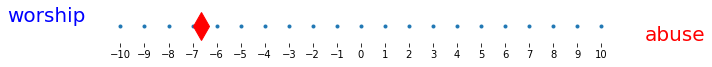

-5.923859


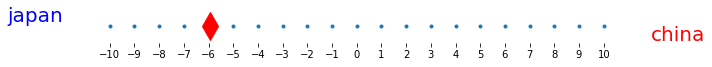

-5.4435105


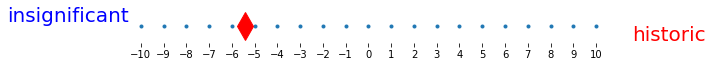

-5.234128


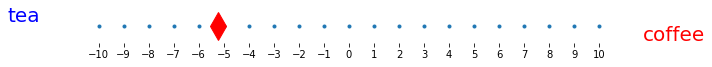

-4.661576


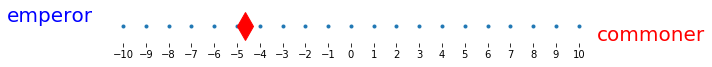

4.345527


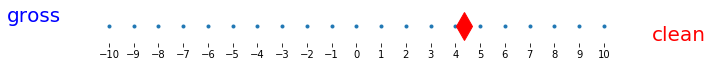

-4.300616


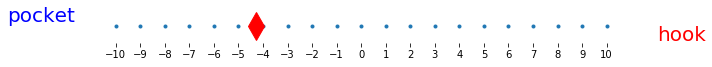

-4.290687


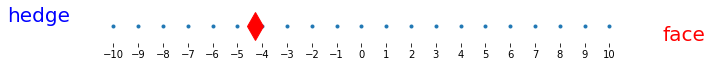

-4.1783957


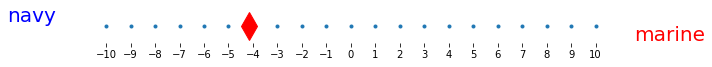

4.1563187


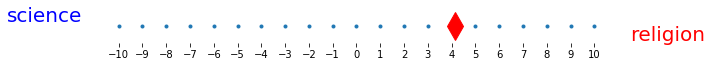

In [234]:
getMeaningOfWord("shinto",orthogonal_antonymy_vector, word2vecPolar, 10 )

In [47]:
######### Task specific code....
command_list = ['python3', 
                    r'C:\Users\Jan\Desktop\PraktikumSS20\POLAR-master\Downstream Task\TREC\classify_task.py',
                     std_nrml_embedding_path,
                     '2',
                     r'C:\Users\Jan\Desktop\PraktikumSS20\POLAR-master\Downstream Task\TREC\data\qa_train_X.pickle',
                     r'C:\Users\Jan\Desktop\PraktikumSS20\POLAR-master\Downstream Task\TREC\data\qa_train_y.pickle',
                     r'C:\Users\Jan\Desktop\PraktikumSS20\POLAR-master\Downstream Task\TREC\data\qa_val_X.pickle',
                     r'C:\Users\Jan\Desktop\PraktikumSS20\POLAR-master\Downstream Task\TREC\data\qa_val_y.pickle',
                     r'C:\Users\Jan\Desktop\PraktikumSS20\POLAR-master\Downstream Task\TREC\data\qa_test_X.pickle',
                     r'C:\Users\Jan\Desktop\PraktikumSS20\POLAR-master\Downstream Task\TREC\data\qa_test_y.pickle'
                    ]



result = subprocess.run(command_list, stdout=subprocess.PIPE, shell=True)
print(result.stdout)
print('finished sentiment task')
################
del temp_model
    
os.remove(std_nrml_embedding_path)
os.remove(embedding_path)

b''
finished sentiment task


In [186]:
def plotPolar(left, right, value):
    fig, ax1 = plt.subplots()
    fig.set_figheight(1)
    fig.set_figwidth(10)

    val = 0
    ar = np.arange(-10,11) 
    ax1.plot(ar, np.zeros_like(ar) + val, '.')
    ax1.plot(value, 0, 'd', linewidth=2, markersize=20, color='r')
    ax1.set_ylabel(left, color='b',rotation=0, size=20, labelpad=50)
    ax1.set_yticks([])
    ax1.set_xticks(ar)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)

    ax2 = ax1.twinx()
    ax2.set_ylabel(right, color='r',rotation=0, size=20, labelpad=50)
    ax2.set_yticks([])
    ax1.grid(False)
    ax2.grid(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    
    
    
    fig.tight_layout()
    plt.show()